<font size="2"> 

### **EN2550 Assignment 2 on Fitting and Alignment** 
+ *by Rajapaksha R.M.P.A.P. - 190484T* 
+ *Github Repository -*
+ *Email -* 
#### Question 1 - Using RANSAC method for finding the best fitting circle 
- step 1 - randomly choose a set of 3 points from the data set.
- step 2 - find the *circumscribed circle* of the triangle formed by the selected 3 points. 
- step 3 - finding the *Inlier* count of the model. 
> + Here, the Inliers are the points that reside within a certain threshold distance $t$ from the circumference of the estimated circle. As given in the code snippet *Listing 1*, these inliers are distributed according to a *Gaussian distribution* with a *variance* value $\sigma$ equal to $1/16$ times the radius of the original circle. 
> + Therefore, an expression for the threshold value $t$ can be found in terms of the radius of the estimated circle $r$, such that $95$% of the points of inliers are covered by the threshold limit as $ t = 1.96\sigma \ {\small (from \ Standard \ Normal \ Distribution \ Tables)} \Longrightarrow t = 1.96 \times r/16 = 0.1225 \ r$.  
> + Furthermore, if we assume that the estimated circle has a radius around length $10$ (as given in the code), then a single value can be given as a common threshold for all estimations. $ t_{common} = 0.1225 \times 10 = 1.225 $ 
- step 4 - if there are $d$ or more inliers, accept the estimation. 
> + To decide whether an estimation is exactly a good fitting model, its inlier count must exceed a certain limit, which is known as the *consensus set size* $d$. 
> + Since there are 50 inliers for the circle, and a good fitting model is expected to cover at least a 95% of those points, the consensus set size $d$ can be found as 
$ d = 0.95 \times halfn = 0.95 \times 50 = 47.5 \backsimeq 47 $. 

Store the data about the estimated circle and its inliers in a dictionary. 

This above process has to be repeated over a number of times to ensure that there is a sufficient probability that at least one sample would be free of any outlier. If the targeted probability of having at least one successful uncontaminated estimation is $p$ and the outlier ratio is $e$, then the number of repetition required to achieve $p$ can be found by the equation; 
$ N = log(1-p) / log(1 - (1-e)^s) $. 

Let us assume a reasonably higher $p$ value as $0.99$ [i.e. a $99$% success rate]. And it is easier to see that the outlier ratio $e$ is equal to $50$%. Thus, a minimum value for $N$ can be found out as follows. $ N = log(1-0.99) / log(1 - (1-0.5)^3) \Longrightarrow N = 34.48 \backsimeq 35 $ 

Finally, the circle with the maximum inlier count is chosen as the **best estimated circle** for the point distribution. Then using the *Least-Squares Circle Fit* method proposed by *Randy Bullock*, the **best-fit circle** will be determined for the inlier points of the best estimation. If there are more than one estimation with the maximum inlier count, then the refitted circle with the smallest mean error will be considered to be the best fit. 

In [1]:
# importing libraries 
import numpy as np
from scipy import linalg 
from scipy.optimize import minimize 
import cv2 as cv 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [87]:
def leastSquaresFitCircle(points): 
    "finds the best fitting circle for a set of inlier points using the Least-Square Fitting Algorithm" 
    N = len(points); x_ = sum(points[:, 0])/N; y_ = sum(points[:, 1])/N # mean values 
    u = np.array([(xi-x_) for xi in points[:, 0]]); v = np.array([(yi-y_) for yi in points[:, 1]]) 
    Suu = sum([ui**2 for ui in u]);  Svv = sum([vi**2 for vi in v])
    Suv = Svu = sum([ui*vi for ui in u for vi in v]) 
    Suuu = sum([ui**3 for ui in u]); Svvv = sum([vi**3 for vi in v])
    Suvv = sum([ui*vi**2 for ui in u for vi in v]); Svuu = sum([vi*ui**2 for ui in u for vi in v])

    A = np.array([[Suu, Suv], 
                  [Svu, Svv]]) 
    B = np.array([[1/2 * (Suuu + Suvv)],
                  [1/2 * (Svvv + Svuu)]])
    (uc, vc) = ((np.linalg.inv(A) @ B).T).reshape(2)    
    (xc, yc) = (uc + x_, vc + y_)                   # center 
    R = np.sqrt(uc**2 + vc**2 + (Suu+Svv)/N)        # radius 
    mean_Error = sum([abs((xi-xc)**2 + (yi-yc)**2 - R**2) for (xi, yi) in points])/N 
    return (xc, yc, R, mean_Error) 

def RANSACcircle(points, N, t, d): 
     "finds the best fitting circle for a given point set using RANSAC method" 
     trial = 0; CircleDict = {} 
     while (trial < N): # perform N number of estimations. 

          # --------------- randomly choose a set of 3 points from the point set --------------- 
          (i1, i2, i3) = np.random.randint(0, len(points), 3)    # finding 3 random indices in 'points' array
          if (len(set((i1, i2, i3))) < 3): N += 1; continue      # if the points are not distinct, then reject the sample
          x1, y1 = points[i1]; x2, y2 = points[i2]; x3, y3 = points[i3]

          # ----- finding the circumscribed circle of the triangle formed by the 3 points ------
          A = np.array([[(x1-x2), (y1-y2)], 
                        [(x1-x3), (y1-y3)]])
          B = np.array([[1/2 * (x1**2-x2**2 + y1**2-y2**2)],
                        [1/2 * (x1**2-x3**2 + y1**2-y3**2)]])
          center = ((np.linalg.inv(A) @ B).T).reshape(2) 
          xO = center[0]; yO = center[1]          # circumcenter 
          r = np.sqrt((x1-xO)**2 + (y1-yO)**2)    # radius 

          if (r > 12) or not (-12 <= xO <= 12) or not (-12 <= yO <= 12): continue # rejecting the circle if out of the region

          # ------------------------------ finding the Inliers ---------------------------------
          inliers = [] 
          for point in points: 
               (x, y) = point 
               if (np.abs(np.sqrt((x-xO)**2 + (y-yO)**2) - r) <= t): inliers.append(point)

          # ------------------- storing the data about the estimated circle ---------------------
          inliers = np.array(inliers) 
          if (len(inliers) >= d): # if inlier count exceeds the consensus set size d, accept the estimation.
               CircleDict[(xO, yO, r, i1, i2, i3)] = inliers 
          trial += 1 # process is complete for the selected sample. 

     max_inlier_count = max([len(inliers) for inliers in CircleDict.values()]) 
     best_estimations = [circle for circle in CircleDict if len(CircleDict[circle]) == max_inlier_count] 
     best_fit_circles = [leastSquaresFitCircle(CircleDict[circle]) for circle in best_estimations] 
     
     if len(best_fit_circles) == 1: return (best_estimations[0] + best_fit_circles[0]), CircleDict[best_estimations[0]] 
     else: # if there are more than one estimations with max inlier count, chose the one with min error. 
          i = min(range(len(best_fit_circles)), key = lambda j: best_fit_circles[j][3])
          return (best_estimations[i] + best_fit_circles[i]), CircleDict[best_estimations[i]] 

In [98]:
def plotting(param): 
    sample = np.array([X[i] for i in (i1, i2, i3)]) 
    bestEstimation = plt.Circle((xO, yO), r, color='b', fill = False, label = "Best Sample") # best sample estimation 
    bestFitCircle  = plt.Circle((xc, yc), R, color='r', fill = False, label = "RANSAC")      # best-fit circle (RANSAC) 

    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_aspect('equal')
    ax.add_patch(bestEstimation); ax.add_patch(bestFitCircle)    # plotting the circles 
    ax.scatter(X[:, 0], X[:, 1], c = 'royalblue', marker = 'o', label = "outliers")            # plotting the point distributions 
    ax.scatter(inliers[:, 0], inliers[:, 1], c = 'limegreen', marker = 'o', label = "inliers") # plotting the inliers 
    ax.scatter(sample[:, 0], sample[:, 1], c = 'r', marker = 'o', label = "best sample")       # plotting the sample points 
    ax.scatter(xO, yO, c = 'b', s = 50, marker = '+')       # center of Best Sample 
    ax.scatter(xc, yc, c = 'r', s = 50, marker = '+')       # center of RANSAC 
    plt.legend() 

N = 100     # total number of points 
half_n = N//2 

# creating a cluster of random points around a known circle 
r = 10      # radius 
s = r/16    # variance 

t = np.random.uniform(0, 2*np.pi, half_n) 
n = s * np.random.randn(half_n) 

x, y = (r+n)*np.cos(t), (r+n)*np.sin(t) 
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# creating a cluster of random points around a known straight line 
m, b = -1, 2
x = np.linspace(-12, 12, half_n) 
y = m*x + b + s*np.random.rand(half_n) 
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1))) 
X = np.vstack((X_circ, X_line)) 

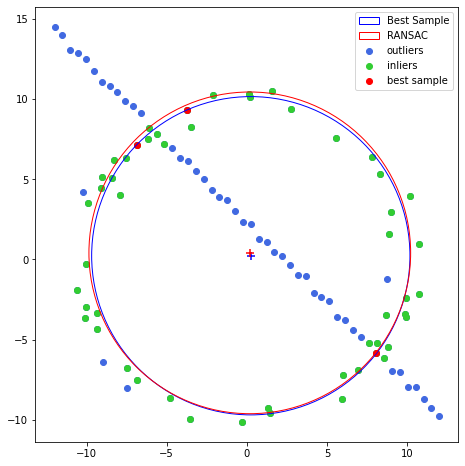

In [131]:
# ------------------------- tuning the parameters --------------------------- 
N = 35      # number of estimations 
t = 1.225   # common threshold 
d = 47      # minimum inlier count 

# -------------------- finding the best fitting circle ----------------------
(xO, yO, r, i1, i2, i3, xc, yc, R, Error), inliers = RANSACcircle(X, N, t, d) 
# ------------------------- plotting the results ----------------------------
plotting(1) 

<font size="2"> 

#### Question 4 - Computing the Best Homography using RANSAC Method 


In [45]:
# --------------------- opening the two images (img1 and 5) -----------------
img1 = cv.imread("graf/img4.ppm", cv.IMREAD_GRAYSCALE); assert img1 is not None 
img5 = cv.imread("graf/img5.ppm", cv.IMREAD_GRAYSCALE); assert img5 is not None 

In [31]:
img1 = cv.imread('box.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img5,None)
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


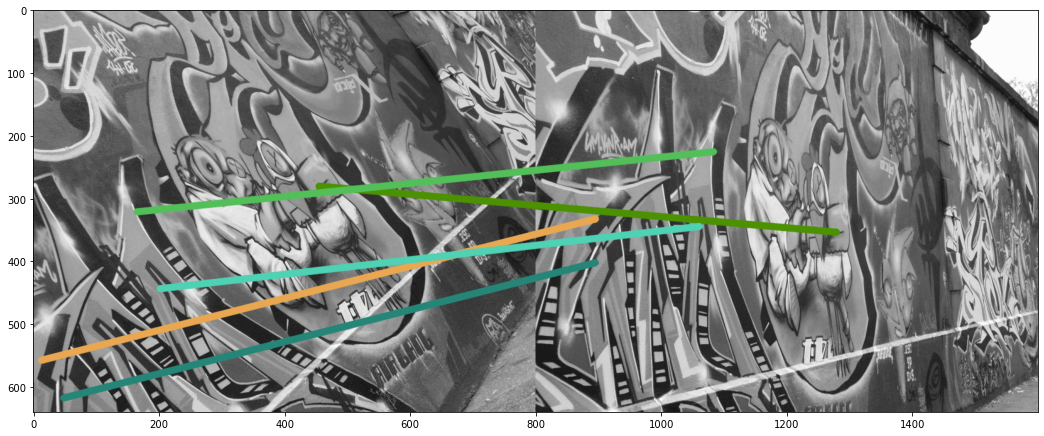

In [46]:
# ******************************** question 3 ******************************* 
# ------------- part (a) - Computing and Matching SIFT Features ------------- 
SIFT = cv.SIFT_create()         # initializing SIFT detector 
keys1, descriptors1 = SIFT.detectAndCompute(img1, None) 
keys5, descriptors5 = SIFT.detectAndCompute(img5, None) 

bf = cv.BFMatcher(crossCheck=True) # initializing Brute Force Matcher with default parameters for SIFT features 
matches = bf.match(descriptors1, descriptors5) 
matches = sorted(matches, key = lambda x:x.distance)

# visualizing the matches 
thickness = 10 
imgM = cv.drawMatches(img1, keys1, img5, keys5, matches[:5], None, matchesThickness=thickness, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, ax = plt.subplots(figsize=(18, 9)) 
ax.imshow(imgM)